In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

#Data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Hypertuning parameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Evaluate models
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Frame the problem

We want to predict based on the features, predict if a certain passenger on Titanic will survive or not.

# Get the Data

In [68]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
gender_submission=pd.read_csv("data/gender_submission.csv")

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [70]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We can see we are missing 20% of the value age, this is reasonably small enough to fill in with mean or median.
Cabin however is too many missing values to be able to do anything meaningful with.

# Explore the data

## Data dictionairy
Survived: Survival 0 = No, 1 = Yes

Pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd

Sibsp: Number of siblings / spouses aboard the Titanic

Parch: Number of parents / children aboard the Titanic

Ticket: Ticket number

Fare: Passenger fare

Cabin: Cabin number

Embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [71]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check correlations early on

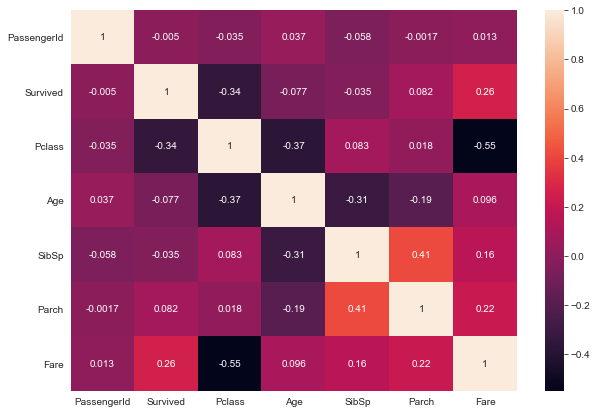

In [73]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(), annot=True);

C:\Users\Frank\anaconda3\envs\dat158\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


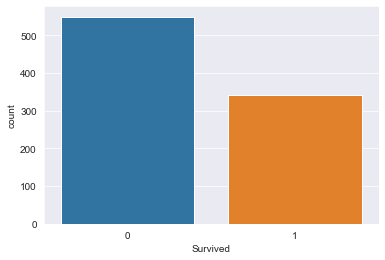

In [74]:
#Number of people who survived
sns.set_style('darkgrid')
sns.countplot(train['Survived']);

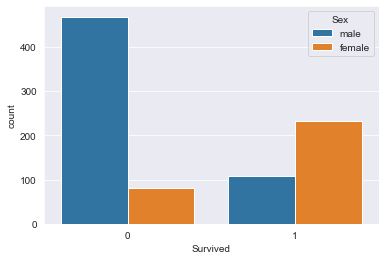

In [75]:
sns.countplot(x='Survived', hue='Sex', data=train);

Females are more likely to survive.

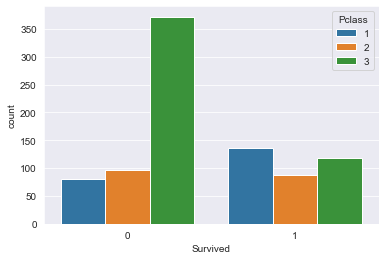

In [76]:
sns.countplot(x='Survived', hue='Pclass', data=train);

Look at correlations with survival with other features:

In [77]:
train.groupby('Pclass')[['Survived']].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [78]:
train.groupby('Sex')[['Survived']].mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [79]:
train.groupby('Parch')[['Survived']].mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


In [80]:
train.groupby('SibSp')[['Survived']].mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


We can also see that people who were at class 1 were more likely to survive than 2 and 3.

C:\Users\Frank\anaconda3\envs\dat158\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


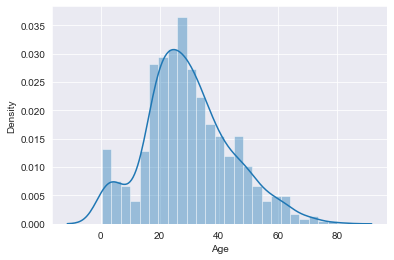

In [81]:
sns.distplot(train['Age'].dropna(),bins=25);

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


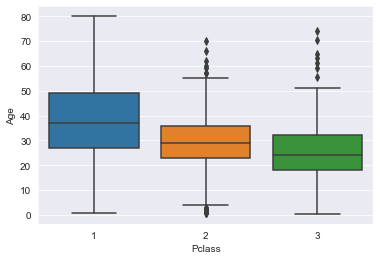

In [83]:
sns.boxplot(x='Pclass',y='Age',data=train);

Here we can see the age is higher for people at first class, which makes sense.

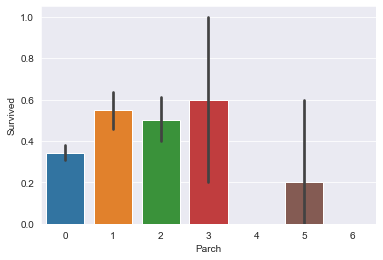

In [84]:
sns.barplot(x = 'Parch', y= 'Survived', data= train)
plt.show()

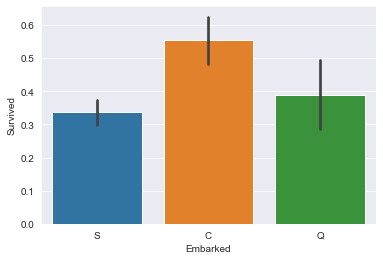

In [85]:
sns.barplot(x= 'Embarked', y = 'Survived', data= train)
plt.show()

In [86]:
#train_data is training data ready to be preprocessed
train_data = train
test_data = test

## Data Preprocessing

We have four features that we might consider dropping before we do any preprocessing and filling in the missing values.
 - Cabin - is missing alot of values
 - PassengerId - does not correlate to survival
 - Name - names does not necessarily relate to survival
 - Ticket - ticket numbers does not necessarily relate to survival

In [87]:
train_data = train_data.drop(['Cabin','PassengerId','Ticket','Name'], axis=1)
test_data = test_data.drop(['Cabin','Ticket','Name'], axis=1)
clean_df = [train_data, test_data]

In [88]:
train_data.shape

(891, 8)

In [89]:
test_data.shape

(418, 8)

In [90]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [91]:
median = train_data["Age"].median() 
train_data["Age"].fillna(median, inplace=True)

In [92]:
median = test_data["Age"].median() 
test_data["Age"].fillna(median, inplace=True)

In [93]:
#Here we drop the columns missing rest of the Embarked
train_data = train_data.dropna()

In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


To deal with categorical features and deal with strings we can use OnehotEncoder or pandas dummy variables.

In [95]:
result = OneHotEncoder().fit_transform(train_data['Sex'].values.reshape(-1,1)).toarray()
train_data['Sex'] = pd.DataFrame(result, index = train_data.index)

<ipython-input-95-694327b0bd81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Sex'] = pd.DataFrame(result, index = train_data.index)


In [96]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0.0,22.0,1,0,7.2500,S
1,1,1,1.0,38.0,1,0,71.2833,C
2,1,3,1.0,26.0,0,0,7.9250,S
3,1,1,1.0,35.0,1,0,53.1000,S
4,0,3,0.0,35.0,0,0,8.0500,S


In [97]:
result = OneHotEncoder().fit_transform(test_data['Sex'].values.reshape(-1,1)).toarray()
test_data['Sex'] = pd.DataFrame(result, index = test_data.index)

In [98]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0.0,34.5,0,0,7.8292,Q
1,893,3,1.0,47.0,1,0,7.0000,S
2,894,2,0.0,62.0,0,0,9.6875,Q
3,895,3,0.0,27.0,0,0,8.6625,S
4,896,3,1.0,22.0,1,1,12.2875,S


In [99]:
result = OneHotEncoder().fit_transform(train_data['Embarked'].values.reshape(-1,1)).toarray()
train_data['Embarked'] = pd.DataFrame(result, index = train_data.index)

<ipython-input-99-2fa16db831ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Embarked'] = pd.DataFrame(result, index = train_data.index)


In [100]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0.0,22.0,1,0,7.2500,0.0
1,1,1,1.0,38.0,1,0,71.2833,1.0
2,1,3,1.0,26.0,0,0,7.9250,0.0
3,1,1,1.0,35.0,1,0,53.1000,0.0
4,0,3,0.0,35.0,0,0,8.0500,0.0


In [101]:
result = OneHotEncoder().fit_transform(test_data['Embarked'].values.reshape(-1,1)).toarray()
test_data['Embarked'] = pd.DataFrame(result, index = test_data.index)

In [102]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    float64
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         417 non-null    float64
 7   Embarked     418 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 26.2 KB


Adding fare band and age band from kaggle tutorial

In [103]:
#Data to be cleaned
clean_df = [train_data, test_data]

In [104]:
train_data['AgeBand'] = pd.cut(train_data['Age'], 5)
train_data.groupby('AgeBand')[['Survived']].mean()

,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.344168
"(32.252, 48.168]",0.401070
"(48.168, 64.084]",0.426471
"(64.084, 80.0]",0.090909


In [105]:
for dataset in clean_df:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
0,0,3,0.0,1.0,1,0,7.2500,0.0,"(16.336, 32.252]"
1,1,1,1.0,2.0,1,0,71.2833,1.0,"(32.252, 48.168]"
2,1,3,1.0,1.0,0,0,7.9250,0.0,"(16.336, 32.252]"
3,1,1,1.0,2.0,1,0,53.1000,0.0,"(32.252, 48.168]"
4,0,3,0.0,2.0,0,0,8.0500,0.0,"(32.252, 48.168]"


In [106]:
train_data = train_data.drop(['AgeBand'], axis=1)
clean_df = [train_data, test_data]
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0.0,1.0,1,0,7.2500,0.0
1,1,1,1.0,2.0,1,0,71.2833,1.0
2,1,3,1.0,1.0,0,0,7.9250,0.0
3,1,1,1.0,2.0,1,0,53.1000,0.0
4,0,3,0.0,2.0,0,0,8.0500,0.0


In [107]:
test_data['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0.0,2.0,0,0,7.8292,0.0
1,893,3,1.0,2.0,1,0,7.0000,0.0
2,894,2,0.0,3.0,0,0,9.6875,0.0
3,895,3,0.0,1.0,0,0,8.6625,0.0
4,896,3,1.0,1.0,1,1,12.2875,0.0


In [108]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data.groupby('FareBand')[['Survived']].mean()

,Survived
FareBand,
"(-0.001, 7.896]",0.197309
"(7.896, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.577273


In [109]:
for dataset in clean_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_data = train_data.drop(['FareBand'], axis=1)
combine = [train_data, test_data]

In [110]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0.0,2.0,0,0,0,0.0
1,893,3,1.0,2.0,1,0,0,0.0
2,894,2,0.0,3.0,0,0,1,0.0
3,895,3,0.0,1.0,0,0,1,0.0
4,896,3,1.0,1.0,1,1,1,0.0


## Building models

In [111]:
#X_train = train_data.drop("Survived", axis=1)
#Y_train = train_data["Survived"]
#X_test  = test_data.drop("PassengerId", axis=1).copy()
# tried using above code but got "Found input variables with inconsistent numbers of samples: [889, 711]"
#Used info() in bot but saw nothing with 711 samples. So decided to use train test split instead
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Survived',axis=1), 
                                                    train_data['Survived'], test_size=0.20, 
                                                    random_state=42)

Logistic Regression

Logistic Regression is the basic model which by using a logistic function is able to measure the relationship
between categorical dependent and one or more independent variables by estimating probabilities. Reference Wikipedia.

In [112]:
log = LogisticRegression()
log.fit(X_train, y_train)
log_pred = log.predict(X_test)
print(confusion_matrix(y_test, log_pred))
print(accuracy_score(y_test, log_pred))

[[86 23]
 [15 54]]
0.7865168539325843


K-Nearest Neighbours

This classifier as in the name implements learning based on the k nearest neighbors.

In [113]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
print(confusion_matrix(y_test, knn_pred))
print(accuracy_score(y_test, knn_pred))

[[87 22]
 [16 53]]
0.7865168539325843


DecisionTreeClassifier

This classifier can be used for predicting categorical and countinuous variables. It splits data down
into subsets and keeps going until the features inside the branch all belong to the same class.

In [114]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)
print(confusion_matrix(y_test, dtc_pred))
print(accuracy_score(y_test, dtc_pred))

[[85 24]
 [18 51]]
0.7640449438202247


GaussianNB

Based on the Bayes theorem this classifier assumes all the features are independent. It predicts membership
probabilities for each class such as the probability that given record or data belongs to a particular class.

In [115]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_pred = gnb.predict(X_test)
print(confusion_matrix(y_test, gnb_pred))
print(accuracy_score(y_test, gnb_pred))

[[77 32]
 [13 56]]
0.7471910112359551


Adaboost

Adaboost also known as adaptive boosting, it transforms a bunch of weak learners into a strong one. Adaboost is also sensitive to outliers.

In [116]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)
print(confusion_matrix(y_test, ada_pred))
print(accuracy_score(y_test, ada_pred))

[[85 24]
 [13 56]]
0.7921348314606742


RandomForest

The basic idea behind the randomforest tree is to combine multiple decision trees to determine
the final output.

In [117]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(confusion_matrix(y_test, rf_pred))
print(accuracy_score(y_test, rf_pred))

[[87 22]
 [17 52]]
0.7808988764044944


Hyperparameter tuning

In [118]:
rf2 = RandomForestClassifier()
# rfc_params_grid = {
#     'n_estimators' : [550, 600, 650, 700],
#     'max_depth' : [5, 7, 9],
#     'max_features': [4, 6, 8],
#     'min_samples_split' : [3, 4, 6],
# }

rf_params_grid = {
    'n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'max_depth': np.random.randint(1, (len(X_train.columns)*.85),20),
    'max_features': np.random.randint(1, len(X_train.columns),20),
    'min_samples_split':[2,4,6,8,10,20,40,60,100], 
}

In [119]:
gscv_random_classifier = RandomizedSearchCV(rf2, rf_params_grid, cv = 5, n_jobs = -1, verbose = 5)

gscv_random_classifier.fit(X_train, y_train)

pred = gscv_random_classifier.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   16.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.2s finished


In [120]:
print(gscv_random_classifier.best_estimator_)
print(gscv_random_classifier.best_score_)
print(gscv_random_classifier.best_params_)
bestEstimator = gscv_random_classifier.best_estimator_
bestParams = gscv_random_classifier.best_params_

RandomForestClassifier(max_depth=4, max_features=6, min_samples_split=4)
0.8157391903870778
{'n_estimators': 100, 'min_samples_split': 4, 'max_features': 6, 'max_depth': 4}


In [121]:
rf3 = RandomForestClassifier(max_depth=4, max_features=3, min_samples_split=8,
                       n_estimators=1250)

rf3.fit(X_train, y_train)
rf3_pred = rf3.predict(X_test)
print(confusion_matrix(y_test, rf3_pred))
print(accuracy_score(y_test, rf3_pred))

[[91 18]
 [18 51]]
0.797752808988764


Could probably made a list of models and print scores for each one instead of trying
one by one.

# Conclusion

Random forest hypertuned and adaboost did exactly the same, however I chose Random forest since it is the one I am
most comfortable of using at this point. Kind of unsure if the last "fit" and predict is what is being used in deployed, since we have multiple models here but that is the one I picked.

# Afterthought

Deployment input will be based on the fareband and ageband, so instead of scaling i choose to use the kaggle code such that the modeltraining went much faster. I would also possibly build a pipeline but unsure its needed here, maybe to discard the fareband and ageband to then pipeline standardisation. I would also pick a harder dataset, but midway I found it to be a bit more time consuming than thought it would, so I chose the titanic dataset since I already got so far. I would also like a tutorial if possible how to deploy our model along with pipline.

## Export trained model

In [122]:
NB_DIR = Path.cwd()

In [123]:
MODEL_DIR = NB_DIR/'..'/'models'

In [124]:
from joblib import dump

In [125]:
dump(log, MODEL_DIR/'rf3_model.joblib', compress=6)

['C:\\Users\\Frank\\Downloads\\python\\DAT158ML\\test\\Titanic\\nbs\\..\\models\\rf3_model.joblib']